## Augsbrug OParl Analyse

In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from dateutil import parser
import time


In [ ]:
# 1. Konfiguration: Der echte Endpunkt für Augsburg
# Viele Städte nutzen 'ris-muenchen.de' oder ähnliche Software-Provider.
# Für Augsburg ist der Einstiegspunkt (System URL) oft:
OPARL_SYSTEM_URL = "https://www.augsburg.sitzung-online.de/public/oparl/system"

# Cache für den Meeting-Endpoint, damit wir ihn nicht jedes Mal neu holen müssen
_MEETING_ENDPOINT_CACHE = None

def get_meeting_endpoint():
    """
    Navigiert durch die OParl-Struktur: System -> Bodies List -> Body -> Meeting-Endpoint
    """
    global _MEETING_ENDPOINT_CACHE

    # Wenn bereits gecacht, direkt zurückgeben
    if _MEETING_ENDPOINT_CACHE:
        return _MEETING_ENDPOINT_CACHE

    # Schritt 1: Hole System-Objekt
    system_response = requests.get(OPARL_SYSTEM_URL, timeout=10)
    system_data = system_response.json()

    # Schritt 2: Extrahiere Bodies-List-URL
    bodies_url = system_data.get('body')
    if isinstance(bodies_url, list):
        bodies_url = bodies_url[0] if bodies_url else None

    if not bodies_url:
        print("⚠️ Keine Body-URL gefunden!")
        return None

    # Schritt 3: Hole Bodies-Liste
    bodies_response = requests.get(bodies_url, timeout=10)
    bodies_data = bodies_response.json()

    # Extrahiere das erste Body-Objekt aus der Liste
    bodies_list = bodies_data.get('data', [])
    if not bodies_list:
        print("⚠️ Keine Bodies in der Liste gefunden!")
        return None

    # Nimm das erste Body (oder hole die ID und rufe das Body-Objekt ab)
    first_body = bodies_list[0]
    body_id = first_body.get('id')

    print(f"✓ Body gefunden: {first_body.get('name', 'Unbenannt')}")

    # Schritt 4: Hole das vollständige Body-Objekt
    body_response = requests.get(body_id, timeout=10)
    body_data = body_response.json()

    meeting_url = body_data.get('meeting')

    # Cache speichern
    _MEETING_ENDPOINT_CACHE = meeting_url

    return meeting_url

def fetch_meetings(limit_pages=5):
    """
    Holt Sitzungen von der API mit Timeout und besserer Fehlerbehandlung.
    Limit_pages ist wichtig, um den Server beim Testen nicht zu überlasten.
    """
    # Erst den richtigen Endpoint finden
    url = get_meeting_endpoint()

    if not url:
        print("Konnte Meeting-Endpoint nicht finden!")
        return pd.DataFrame()

    meetings_data = []
    page_count = 0
    failed_requests = 0
    max_failures = 3

    print(f"Lade {limit_pages} Seiten Sitzungen...")

    while url and page_count < limit_pages:
        try:
            response = requests.get(url, timeout=15)  # 15 Sekunden Timeout
            response.raise_for_status()
            data = response.json()

            # Die eigentlichen Daten liegen oft im 'data'-Array (je nach OParl Version)
            items = data.get('data', []) if isinstance(data, dict) else data

            for item in items:
                meetings_data.append({
                    'name': item.get('name', 'Unbenannte Sitzung'),
                    'start': item.get('start'),
                    'end': item.get('end'),
                    'organization': item.get('organization', ['Unknown'])[0] if item.get('organization') else 'Unknown'
                })

            # Pagination: Suche den Link zur nächsten Seite
            links = data.get('links', {})
            url = links.get('next')

            page_count += 1
            print(f"  ✓ Seite {page_count}/{limit_pages}: {len(items)} Sitzungen (Total: {len(meetings_data)})")

            # Höflichkeitspause für den Server
            time.sleep(0.15)

            # Reset failure counter bei Erfolg
            failed_requests = 0

        except requests.exceptions.Timeout:
            failed_requests += 1
            print(f"\n⚠️ Timeout bei Seite {page_count + 1} (Versuch {failed_requests}/{max_failures})")
            if failed_requests >= max_failures:
                print("❌ Zu viele Timeouts - breche ab.")
                break
            time.sleep(2)  # Längere Pause bei Timeout

        except requests.exceptions.RequestException as e:
            failed_requests += 1
            print(f"\n⚠️ Netzwerkfehler bei Seite {page_count + 1}: {e}")
            if failed_requests >= max_failures:
                print("❌ Zu viele Fehler - breche ab.")
                break
            time.sleep(2)

        except Exception as e:
            print(f"\n⚠️ Unerwarteter Fehler: {e}")
            break

    print(f"\n✓ Insgesamt {len(meetings_data)} Sitzungen von {page_count} Seiten geladen.")
    return pd.DataFrame(meetings_data)

In [23]:
# Debug: Lass uns die OParl-Struktur verstehen
print("=== OParl API Struktur ===\n")

# 1. System-Ebene
print("1. System-Objekt:")
system_response = requests.get(OPARL_SYSTEM_URL)
system_data = system_response.json()
print(f"   Keys: {list(system_data.keys())}")
print(f"   Body URL: {system_data.get('body')}\n")

# 2. Bodies-Liste
bodies_url = system_data.get('body')
if isinstance(bodies_url, list):
    bodies_url = bodies_url[0]

if bodies_url:
    print("2. Bodies-Liste:")
    bodies_response = requests.get(bodies_url)
    bodies_data = bodies_response.json()
    print(f"   Keys: {list(bodies_data.keys())}")

    bodies_list = bodies_data.get('data', [])
    print(f"   Anzahl Bodies: {len(bodies_list)}")

    if bodies_list:
        print(f"   Erstes Body: {bodies_list[0].get('name', 'Unbenannt')}")
        print(f"   Erstes Body ID: {bodies_list[0].get('id')}\n")

        # 3. Einzelnes Body-Objekt
        body_id = bodies_list[0].get('id')
        print("3. Body-Objekt (Detail):")
        body_response = requests.get(body_id)
        body_data = body_response.json()
        print(f"   Keys: {list(body_data.keys())}")
        print(f"   Meeting URL: {body_data.get('meeting')}\n")

        # 4. Meeting-Liste
        meeting_url = body_data.get('meeting')
        if meeting_url:
            print("4. Meeting-Liste:")
            meeting_response = requests.get(meeting_url)
            meeting_data = meeting_response.json()
            print(f"   Response type: {type(meeting_data)}")
            print(f"   Keys: {list(meeting_data.keys()) if isinstance(meeting_data, dict) else 'Not a dict'}")

            if 'data' in meeting_data and meeting_data['data']:
                print(f"   Anzahl Meetings: {len(meeting_data['data'])}")
                print(f"   Erstes Meeting Keys: {list(meeting_data['data'][0].keys())}")
                print(f"   Erstes Meeting: {meeting_data['data'][0].get('name')} - {meeting_data['data'][0].get('start')}")

=== OParl API Struktur ===

1. System-Objekt:
   Keys: ['id', 'type', 'oparlVersion', 'license', 'body', 'name', 'contactEmail', 'contactName', 'website', 'vendor', 'product', 'created', 'modified', 'web', 'deleted']
   Body URL: https://www.augsburg.sitzung-online.de/public/oparl/bodies

2. Bodies-Liste:
   Keys: ['id', 'type', 'oparlVersion', 'license', 'body', 'name', 'contactEmail', 'contactName', 'website', 'vendor', 'product', 'created', 'modified', 'web', 'deleted']
   Body URL: https://www.augsburg.sitzung-online.de/public/oparl/bodies

2. Bodies-Liste:
   Keys: ['data', 'pagination', 'links']
   Anzahl Bodies: 1
   Erstes Body: Stadt Augsburg
   Erstes Body ID: https://www.augsburg.sitzung-online.de/public/oparl/bodies?id=1

3. Body-Objekt (Detail):
   Keys: ['id', 'type', 'system', 'shortName', 'name', 'organization', 'person', 'meeting', 'paper', 'legislativeTerm', 'agendaItem', 'consultation', 'file', 'locationList', 'legislativeTermList', 'membership', 'location', 'web', '

In [25]:
# 2. Datenanalyse & Bereinigung
# Erhöhe die Anzahl der Seiten, um ältere Daten (2023, 2024) zu erfassen
df = fetch_meetings(limit_pages=50)  # Ca. 1000 Meetings = mehr historische Daten

# Prüfe, ob der DataFrame leer ist oder die nötigen Spalten fehlen
if df.empty:
    print("\n⚠️ FEHLER: DataFrame ist leer! Keine Daten von der API erhalten.")
elif 'start' not in df.columns:
    print(f"\n⚠️ FEHLER: Spalte 'start' fehlt! Verfügbare Spalten: {df.columns.tolist()}")
else:
    print(f"\n📊 Datenübersicht:")
    print(f"   Shape: {df.shape}")
    print(f"   Spalten: {', '.join(df.columns.tolist())}")

    # Konvertiere Strings in echte Datetime-Objekte
    df['start'] = pd.to_datetime(df['start'], utc=True)
    df['end'] = pd.to_datetime(df['end'], utc=True)

    # Feature Engineering: Wochentag und Stunde extrahieren
    # Wir konvertieren nach 'Europe/Berlin', damit 17:00 auch 17:00 ist
    df['start_local'] = df['start'].dt.tz_convert('Europe/Berlin')
    df['weekday'] = df['start_local'].dt.day_name()
    df['hour'] = df['start_local'].dt.hour

    # Reliability Check: Filtern von ungültigen Daten (z.B. Startdatum fehlt)
    df_clean = df.dropna(subset=['start'])

    print(f"\n✓ Rohdaten: {len(df_clean)} Sitzungen geladen.")
    print(f"   Zeitraum (roh): {df_clean['start_local'].min().date()} bis {df_clean['start_local'].max().date()}")
    print(f"\nErste 3 Sitzungen:")
    print(df_clean[['name', 'start_local', 'weekday']].head(3).to_string(index=False))

Lade 50 Seiten Sitzungen...
  Seite 50/50: 20 Sitzungen
✓ Insgesamt 1000 Sitzungen geladen.

📊 Datenübersicht:
   Shape: (1000, 4)
   Spalten: name, start, end, organization

✓ Rohdaten: 1000 Sitzungen geladen.
   Zeitraum (roh): 2019-02-07 bis 2027-12-01

Erste 3 Sitzungen:
                                                               name               start_local   weekday
Sitzung des Ausschusses für Digitalisierung, Organisation, Personal 2027-12-01 14:30:00+01:00 Wednesday
                                      Stadtrat Augsburg (ganztägig) 2026-12-17 09:00:00+01:00  Thursday
   Wirtschaftsförderungs-, Beteiligungs- und Liegenschaftsausschuss 2026-12-16 09:30:00+01:00 Wednesday


### Alternative: Daten mit Threading parallel laden (schneller!)

Wenn das normale Laden zu langsam ist, nutze diese Zelle stattdessen.
**Threading lädt mehrere Seiten gleichzeitig** = 3-5x schneller!

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import os

def fetch_meetings_fast(limit_pages=50, cache_file='data-raw/augsburg_meetings_cache.parquet'):
    """
    Schnellere Variante mit Threading + lokalem Cache.
    Lädt Daten nur einmal von der API, dann aus lokalem File.
    """

    # 1. Prüfe ob Cache existiert
    if os.path.exists(cache_file):
        print(f"📦 Lade Daten aus Cache: {cache_file}")
        df = pd.read_parquet(cache_file)
        print(f"✓ {len(df)} Sitzungen aus Cache geladen (instant!)")
        return df

    print(f"🌐 Kein Cache gefunden - lade von API mit Threading...")

    # 2. Erst alle Seiten-URLs sammeln
    url = get_meeting_endpoint()
    if not url:
        return pd.DataFrame()

    page_urls = []
    page_count = 0

    print("📋 Sammle Seiten-URLs...")
    while url and page_count < limit_pages:
        page_urls.append(url)
        try:
            response = requests.get(url, timeout=10)
            data = response.json()
            links = data.get('links', {})
            url = links.get('next')
            page_count += 1
            if page_count % 10 == 0:
                print(f"   {page_count} URLs gesammelt...")
        except Exception as e:
            print(f"⚠️ Fehler beim URL-Sammeln: {e}")
            break

    print(f"✓ {len(page_urls)} Seiten-URLs gesammelt.\n")

    # 3. Paralleles Laden mit ThreadPool
    def fetch_page(url):
        """Lädt eine einzelne Seite"""
        try:
            response = requests.get(url, timeout=15)
            response.raise_for_status()
            data = response.json()
            items = data.get('data', [])

            meetings = []
            for item in items:
                meetings.append({
                    'name': item.get('name', 'Unbenannte Sitzung'),
                    'start': item.get('start'),
                    'end': item.get('end'),
                    'organization': item.get('organization', ['Unknown'])[0] if item.get('organization') else 'Unknown'
                })
            return meetings
        except Exception as e:
            print(f"⚠️ Fehler bei Seite: {e}")
            return []

    print("⚡ Lade Seiten parallel (bis zu 10 gleichzeitig)...")
    all_meetings = []

    with ThreadPoolExecutor(max_workers=10) as executor:
        futures = {executor.submit(fetch_page, url): i for i, url in enumerate(page_urls)}

        for future in as_completed(futures):
            page_num = futures[future]
            meetings = future.result()
            all_meetings.extend(meetings)
            print(f"  ✓ Seite {page_num + 1}/{len(page_urls)}: {len(meetings)} Meetings (Total: {len(all_meetings)})")

    print(f"\n✓ {len(all_meetings)} Sitzungen geladen!\n")

    # 4. In DataFrame konvertieren
    df = pd.DataFrame(all_meetings)

    # 5. Cache speichern für nächstes Mal
    os.makedirs(os.path.dirname(cache_file), exist_ok=True)
    df.to_parquet(cache_file)
    print(f"💾 Cache gespeichert: {cache_file}")
    print(f"   Nächstes Mal lädt es sofort!\n")

    return df

# Nutze die schnelle Variante
df = fetch_meetings_fast(limit_pages=50)

### Datenverarbeitung

### Organisationsnamen laden

Die API gibt nur URLs zurück - wir müssen die Organisationsnamen separat abrufen.

In [39]:
from concurrent.futures import ThreadPoolExecutor, as_completed

# Cache für Organisationsnamen
_ORG_NAME_CACHE = {}

def get_organization_name(org_url):
    """
    Holt den Namen einer Organisation von ihrer URL.
    Verwendet Caching um API-Calls zu reduzieren.
    """
    if not org_url or org_url == 'Unknown':
        return 'Unbekannt'

    # Prüfe Cache
    if org_url in _ORG_NAME_CACHE:
        return _ORG_NAME_CACHE[org_url]

    # Hole von API
    try:
        response = requests.get(org_url, timeout=10)
        response.raise_for_status()
        org_data = response.json()
        name = org_data.get('name', org_url)

        # Speichere im Cache
        _ORG_NAME_CACHE[org_url] = name
        return name
    except Exception as e:
        print(f"⚠️ Fehler beim Laden von {org_url}: {e}")
        _ORG_NAME_CACHE[org_url] = org_url  # Cache auch Fehler
        return org_url

def enrich_organization_names(df):
    """
    Fügt eine neue Spalte 'organization_name' mit den echten Namen hinzu.
    """
    print("🔄 Lade Organisationsnamen...")

    # Hole unique URLs
    unique_orgs = df['organization'].unique()
    print(f"   {len(unique_orgs)} verschiedene Organisationen gefunden")

    # Lade Namen parallel
    org_names = {}
    with ThreadPoolExecutor(max_workers=10) as executor:
        futures = {executor.submit(get_organization_name, url): url for url in unique_orgs}

        for future in as_completed(futures):
            url = futures[future]
            name = future.result()
            org_names[url] = name
            if len(org_names) % 5 == 0:
                print(f"   {len(org_names)}/{len(unique_orgs)} geladen...")

    # Füge Namen zum DataFrame hinzu
    df['organization_name'] = df['organization'].map(org_names)

    print(f"✓ Organisationsnamen geladen!\n")
    return df

# Wende die Funktion an
df = enrich_organization_names(df)

🔄 Lade Organisationsnamen...
   22 verschiedene Organisationen gefunden
   5/22 geladen...
   5/22 geladen...
   10/22 geladen...
   10/22 geladen...
   15/22 geladen...
   20/22 geladen...
   15/22 geladen...
   20/22 geladen...
✓ Organisationsnamen geladen!

✓ Organisationsnamen geladen!



In [40]:
# Weiter wie gewohnt mit der Datenverarbeitung
if df.empty:
    print("\n⚠️ FEHLER: DataFrame ist leer!")
elif 'start' not in df.columns:
    print(f"\n⚠️ FEHLER: Spalte 'start' fehlt!")
else:
    print(f"\n📊 Datenübersicht:")
    print(f"   Shape: {df.shape}")

    # Konvertiere Strings in echte Datetime-Objekte
    df['start'] = pd.to_datetime(df['start'], utc=True)
    df['end'] = pd.to_datetime(df['end'], utc=True)

    # Feature Engineering
    df['start_local'] = df['start'].dt.tz_convert('Europe/Berlin')
    df['weekday'] = df['start_local'].dt.day_name()
    df['hour'] = df['start_local'].dt.hour

    # Filtern
    df_clean = df.dropna(subset=['start'])

    print(f"\n✓ {len(df_clean)} Sitzungen bereit zur Analyse.")
    print(f"   Zeitraum: {df_clean['start_local'].min().date()} bis {df_clean['start_local'].max().date()}")


📊 Datenübersicht:
   Shape: (1000, 8)

✓ 1000 Sitzungen bereit zur Analyse.
   Zeitraum: 2019-02-07 bis 2027-12-01


In [41]:
# Datenqualitäts-Check: Welche Jahre sind in den Daten?
print("🔍 Datenqualitäts-Check:")
print(f"   Rohdaten vor Filterung: {len(df_clean)} Sitzungen")
print(f"   Jahresbereich (roh): {df_clean['start_local'].dt.year.min()} - {df_clean['start_local'].dt.year.max()}")
print(f"\n   Verteilung nach Jahren:")
year_dist = df_clean['start_local'].dt.year.value_counts().sort_index()
for year, count in year_dist.items():
    marker = "⚠️" if year > 2025 else "✓"
    print(f"   {marker} {year}: {count} Sitzungen")

# Filter: Nur Daten von 2020-2025 (nicht in der Zukunft, nicht zu alt)
from datetime import datetime
today = datetime(2025, 11, 20)
start_date = datetime(2020, 1, 1)
df_clean = df_clean[
    (df_clean['start_local'] >= pd.Timestamp(start_date, tz='Europe/Berlin')) &
    (df_clean['start_local'] <= pd.Timestamp(today, tz='Europe/Berlin'))
].copy()

print(f"\n✓ Nach Filterung (2020-2025): {len(df_clean)} Sitzungen")
print(f"   Neuer Zeitraum: {df_clean['start_local'].min().date()} bis {df_clean['start_local'].max().date()}")

🔍 Datenqualitäts-Check:
   Rohdaten vor Filterung: 1000 Sitzungen
   Jahresbereich (roh): 2019 - 2027

   Verteilung nach Jahren:
   ✓ 2019: 126 Sitzungen
   ✓ 2020: 127 Sitzungen
   ✓ 2021: 137 Sitzungen
   ✓ 2022: 137 Sitzungen
   ✓ 2023: 127 Sitzungen
   ✓ 2024: 122 Sitzungen
   ✓ 2025: 116 Sitzungen
   ⚠️ 2026: 107 Sitzungen
   ⚠️ 2027: 1 Sitzungen

✓ Nach Filterung (2020-2025): 749 Sitzungen
   Neuer Zeitraum: 2020-01-16 bis 2025-11-19


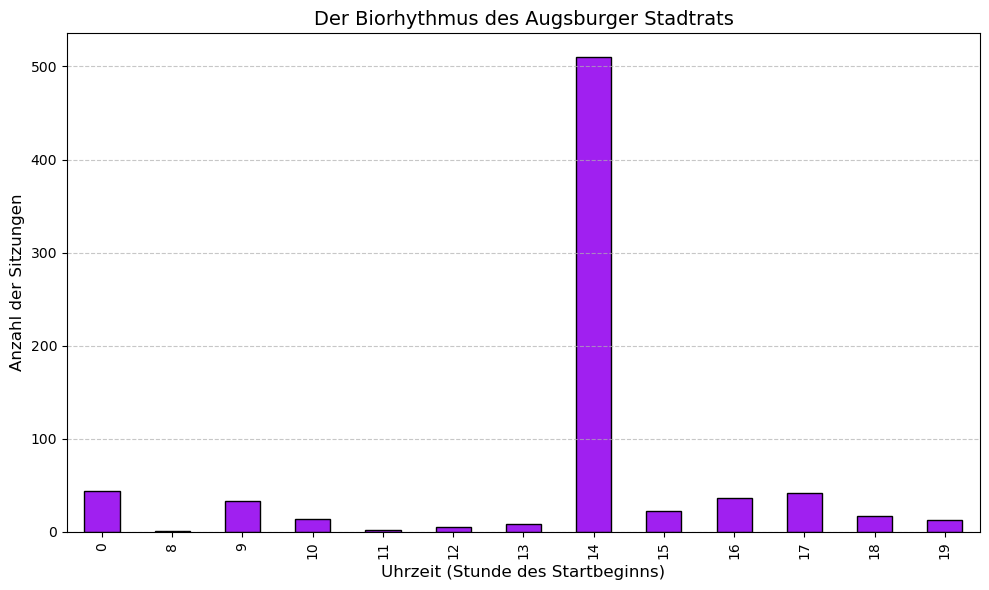

In [42]:
# 3. Visualisierung (Stufe 1: Der Überblick)
# Wann finden Sitzungen statt?
plt.figure(figsize=(10, 6))
counts = df_clean['hour'].value_counts().sort_index()
counts.plot(kind='bar', color='#A020F0', edgecolor='black') # Augsburg-Farbe wäre eigentlich Zirbelnuss-Grün/Rot

plt.title('Der Biorhythmus des Augsburger Stadtrats', fontsize=14)
plt.xlabel('Uhrzeit (Stunde des Startbeginns)', fontsize=12)
plt.ylabel('Anzahl der Sitzungen', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()



In [43]:
# 4. Kleine Text-Ausgabe für den "Aha-Effekt"
latest_meeting = df_clean.loc[df_clean['hour'] >= 20]
if not latest_meeting.empty:
    print("\n--- Nachteulen-Alarm ---")
    print("Beispiele für späte Sitzungen (Start nach 20 Uhr):")
    print(latest_meeting[['name', 'start_local']].head(3))

## Vertiefende Analysen

Jetzt schauen wir uns detaillierter an:
1. Wochentag-Präferenzen
2. Zeitliche Trends
3. Unterschiede nach Organisation/Gremium
4. Die mysteriösen "Mitternachts-Meetings"
5. GeoAnalyse

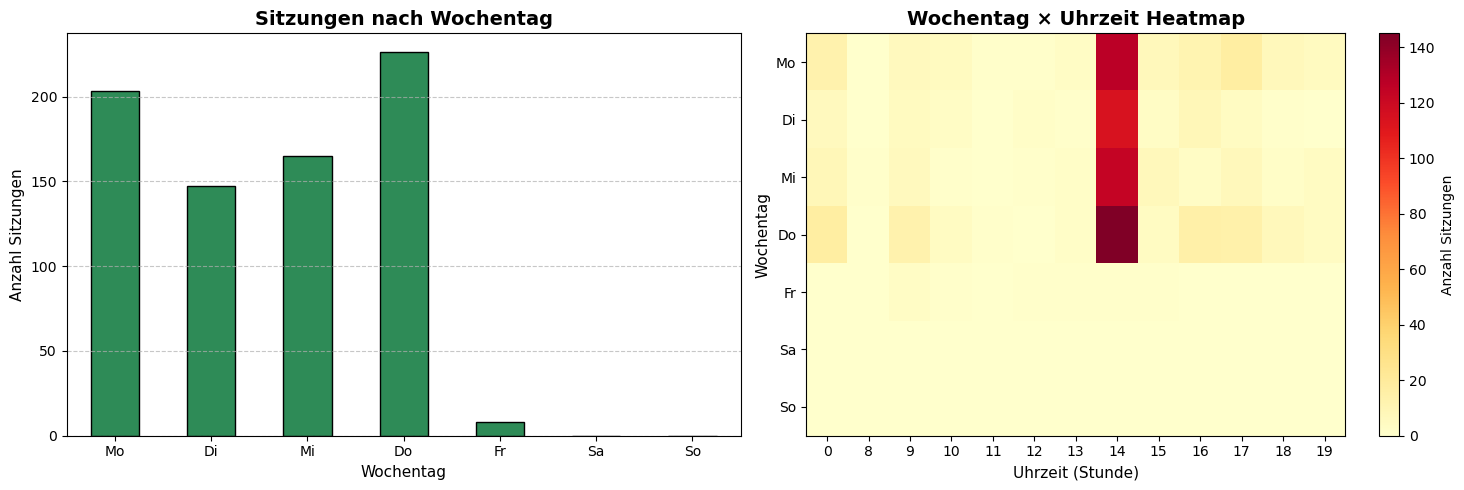


📊 Wochentag-Statistik:
   Beliebtester Tag: Thursday (226 Sitzungen)
   Ruhigster Tag: Saturday (0 Sitzungen)


In [44]:
# 5. Wochentag-Analyse: Wann tagt der Stadtrat am liebsten?
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Linksgrafik: Absolute Zahlen pro Wochentag
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_counts = df_clean['weekday'].value_counts().reindex(weekday_order, fill_value=0)

weekday_counts.plot(kind='bar', ax=ax1, color='#2E8B57', edgecolor='black')
ax1.set_title('Sitzungen nach Wochentag', fontsize=14, fontweight='bold')
ax1.set_xlabel('Wochentag', fontsize=11)
ax1.set_ylabel('Anzahl Sitzungen', fontsize=11)
ax1.set_xticklabels(['Mo', 'Di', 'Mi', 'Do', 'Fr', 'Sa', 'So'], rotation=0)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Rechtsgrafik: Heatmap Wochentag x Uhrzeit
pivot_data = df_clean.groupby(['weekday', 'hour']).size().reset_index(name='count')
pivot_table = pivot_data.pivot(index='weekday', columns='hour', values='count').fillna(0)
pivot_table = pivot_table.reindex(weekday_order, fill_value=0)

im = ax2.imshow(pivot_table, cmap='YlOrRd', aspect='auto')
ax2.set_yticks(range(len(weekday_order)))
ax2.set_yticklabels(['Mo', 'Di', 'Mi', 'Do', 'Fr', 'Sa', 'So'])
ax2.set_xticks(range(len(pivot_table.columns)))
ax2.set_xticklabels(pivot_table.columns)
ax2.set_xlabel('Uhrzeit (Stunde)', fontsize=11)
ax2.set_ylabel('Wochentag', fontsize=11)
ax2.set_title('Wochentag × Uhrzeit Heatmap', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax2, label='Anzahl Sitzungen')

plt.tight_layout()
plt.show()

print(f"\n📊 Wochentag-Statistik:")
print(f"   Beliebtester Tag: {weekday_counts.idxmax()} ({weekday_counts.max()} Sitzungen)")
print(f"   Ruhigster Tag: {weekday_counts.idxmin()} ({weekday_counts.min()} Sitzungen)")

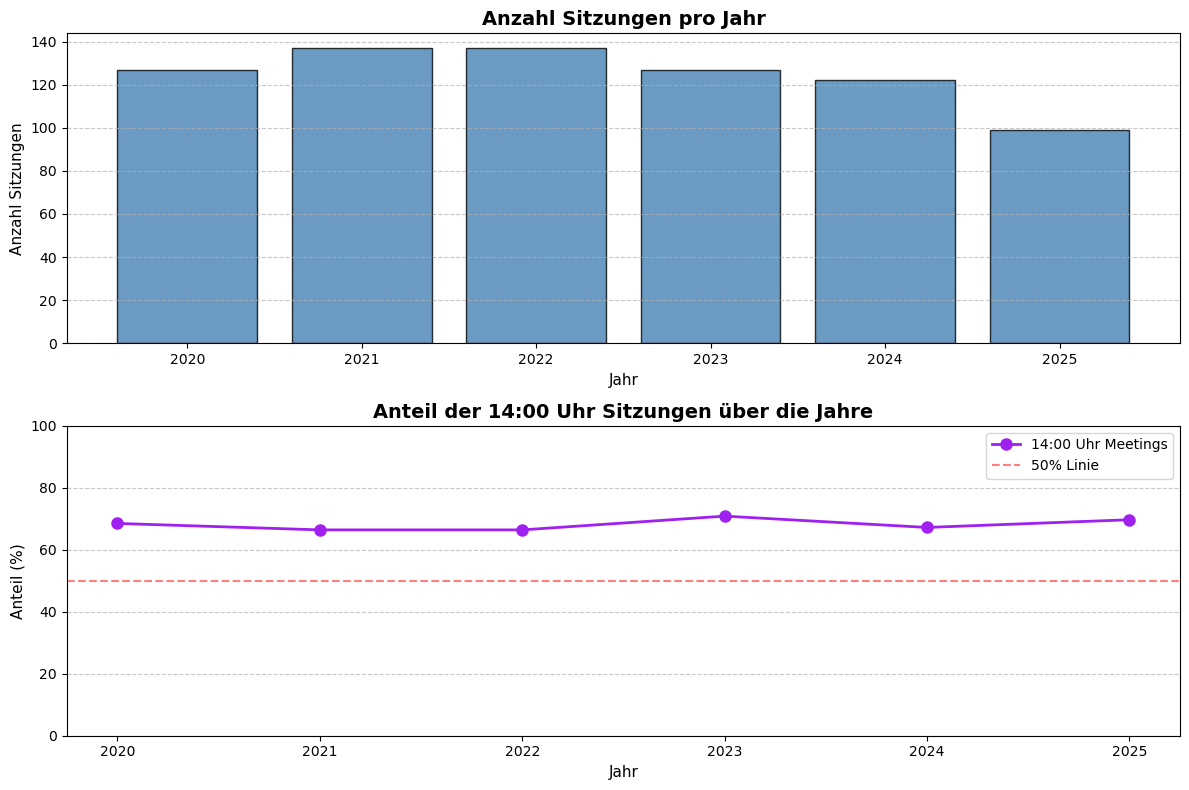


📈 Zeitliche Trends:
   Zeitraum: 2020 - 2025
   Durchschnittliche Meetings/Jahr: 124.8
   14:00 Uhr Präferenz im Zeitverlauf: 66.4% - 70.9%


In [45]:
# 6. Zeitliche Trends: Hat sich das Sitzungsverhalten über die Jahre verändert?
df_clean['year'] = df_clean['start_local'].dt.year
df_clean['month'] = df_clean['start_local'].dt.month

# Gruppiere nach Jahr und berechne Statistiken
yearly_stats = df_clean.groupby('year').agg({
    'hour': lambda x: (x == 14).sum() / len(x) * 100,  # % der 14:00 Meetings
    'name': 'count'  # Gesamtanzahl Meetings
}).rename(columns={'hour': 'pct_14h', 'name': 'total_meetings'})

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Obere Grafik: Meetings pro Jahr
ax1.bar(yearly_stats.index, yearly_stats['total_meetings'], color='#4682B4', edgecolor='black', alpha=0.8)
ax1.set_title('Anzahl Sitzungen pro Jahr', fontsize=14, fontweight='bold')
ax1.set_xlabel('Jahr', fontsize=11)
ax1.set_ylabel('Anzahl Sitzungen', fontsize=11)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Untere Grafik: Anteil der 14:00 Meetings
ax2.plot(yearly_stats.index, yearly_stats['pct_14h'], marker='o', linewidth=2,
         markersize=8, color='#A020F0', label='14:00 Uhr Meetings')
ax2.axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50% Linie')
ax2.set_title('Anteil der 14:00 Uhr Sitzungen über die Jahre', fontsize=14, fontweight='bold')
ax2.set_xlabel('Jahr', fontsize=11)
ax2.set_ylabel('Anteil (%)', fontsize=11)
ax2.set_ylim(0, 100)
ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2.legend()

plt.tight_layout()
plt.show()

print(f"\n📈 Zeitliche Trends:")
print(f"   Zeitraum: {df_clean['year'].min()} - {df_clean['year'].max()}")
print(f"   Durchschnittliche Meetings/Jahr: {yearly_stats['total_meetings'].mean():.1f}")
print(f"   14:00 Uhr Präferenz im Zeitverlauf: {yearly_stats['pct_14h'].min():.1f}% - {yearly_stats['pct_14h'].max():.1f}%")

📋 Top 10 aktivste Gremien:
   1. Stadtrat Augsburg: 72 Sitzungen
   2. Bau-, Hochbau- und Konversionsausschuss (Bauausschuss): 60 Sitzungen
   3. WRK für den Eigenbetrieb Stadtentwässerung Augsburg: 55 Sitzungen
   4. Umwelt-, Klimaschutz- und Gesundheitsausschuss (Umweltausschuss): 45 Sitzungen
   5. Ausschuss für Bildung und Migration (Bildungsausschuss): 43 Sitzungen
   6. WRK für den Eigenbetrieb Abfallwirtschafts- und Stadtreinigungsbetr...: 42 Sitzungen
   7. Wirtschaftsförderungs-, Beteiligungs- und Liegenschaftsausschuss: 42 Sitzungen
   8. Unbekannt: 41 Sitzungen
   9. Finanzausschuss: 37 Sitzungen
   10. Kulturausschuss: 35 Sitzungen


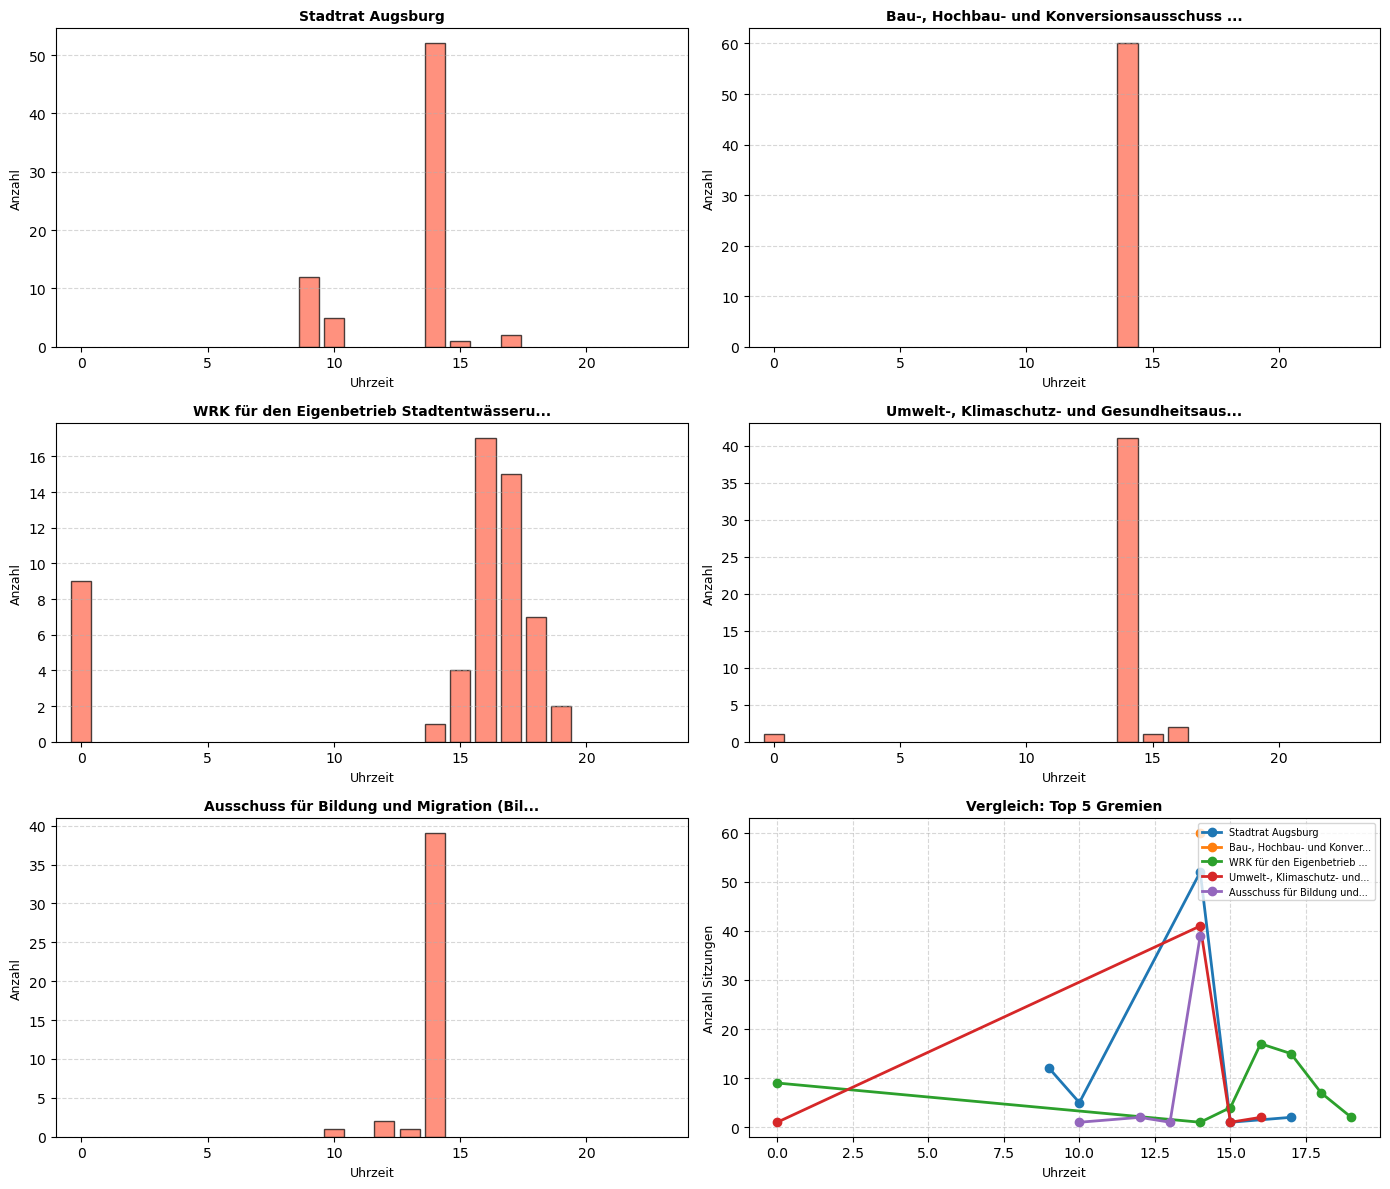

In [46]:
# 7. Organisation/Gremium-Unterschiede: Wer tagt wann?
# Analysiere die Top-Organisationen (jetzt mit echten Namen!)
org_counts = df_clean['organization_name'].value_counts().head(10)

print(f"📋 Top 10 aktivste Gremien:")
for i, (org, count) in enumerate(org_counts.items(), 1):
    org_display = org if len(org) <= 70 else org[:67] + "..."
    print(f"   {i}. {org_display}: {count} Sitzungen")

# Visualisierung: Zeitpräferenzen der Top 5 Gremien
top5_orgs = org_counts.head(5).index
df_top5 = df_clean[df_clean['organization_name'].isin(top5_orgs)]

fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, org in enumerate(top5_orgs):
    org_data = df_top5[df_top5['organization_name'] == org]
    hour_dist = org_data['hour'].value_counts().sort_index()

    axes[idx].bar(hour_dist.index, hour_dist.values, color='#FF6347', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f"{org[:40]}..." if len(org) > 40 else org, fontsize=10, fontweight='bold')
    axes[idx].set_xlabel('Uhrzeit', fontsize=9)
    axes[idx].set_ylabel('Anzahl', fontsize=9)
    axes[idx].grid(axis='y', linestyle='--', alpha=0.5)
    axes[idx].set_xlim(-1, 24)

# Letztes Subplot für Gesamtvergleich
all_orgs_pivot = df_top5.groupby(['organization_name', 'hour']).size().reset_index(name='count')
for org in top5_orgs:
    org_data = all_orgs_pivot[all_orgs_pivot['organization_name'] == org]
    label = org[:25] + "..." if len(org) > 25 else org
    axes[5].plot(org_data['hour'], org_data['count'], marker='o', label=label, linewidth=2)

axes[5].set_title('Vergleich: Top 5 Gremien', fontsize=10, fontweight='bold')
axes[5].set_xlabel('Uhrzeit', fontsize=9)
axes[5].set_ylabel('Anzahl Sitzungen', fontsize=9)
axes[5].legend(fontsize=7, loc='upper right')
axes[5].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

🕵️ Analyse der 44 'Mitternachts'-Meetings:

Stichprobe der Start-Zeiten:
   1. 2025-11-10 00:00:00+01:00 - Umwelt-, Klimaschutz- und Gesundheitsausschuss (Umweltaussch...
   2. 2025-10-29 00:00:00+01:00 - Hinweis: Jugend-, Sozial- und Wohnungsaussschuss verlegt auf...
   3. 2025-10-07 00:00:00+02:00 - Sitzung WRK Altenhilfe entfällt!...
   4. 2025-05-08 00:00:00+02:00 - WRK für den Eigenbetrieb Stadtentwässerung Augsburg - Sitzun...
   5. 2025-04-03 00:00:00+02:00 - WRK für den Eigenbetrieb Stadtentwässerung Augsburg  -  Sitz...

📊 Zeitstempel-Analyse:
   Echte 00:00:00 Timestamps: 44
   Mit Zeit-Information: 0
   Haben End-Zeit: 44
   Ohne End-Zeit: 0


/var/folders/_j/vnx81v553t55x5wp90qkk64m0000gn/T/ipykernel_64963/1314544439.py:44: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  midnight_meetings['year_month'] = midnight_meetings['start_local'].dt.to_period('M')


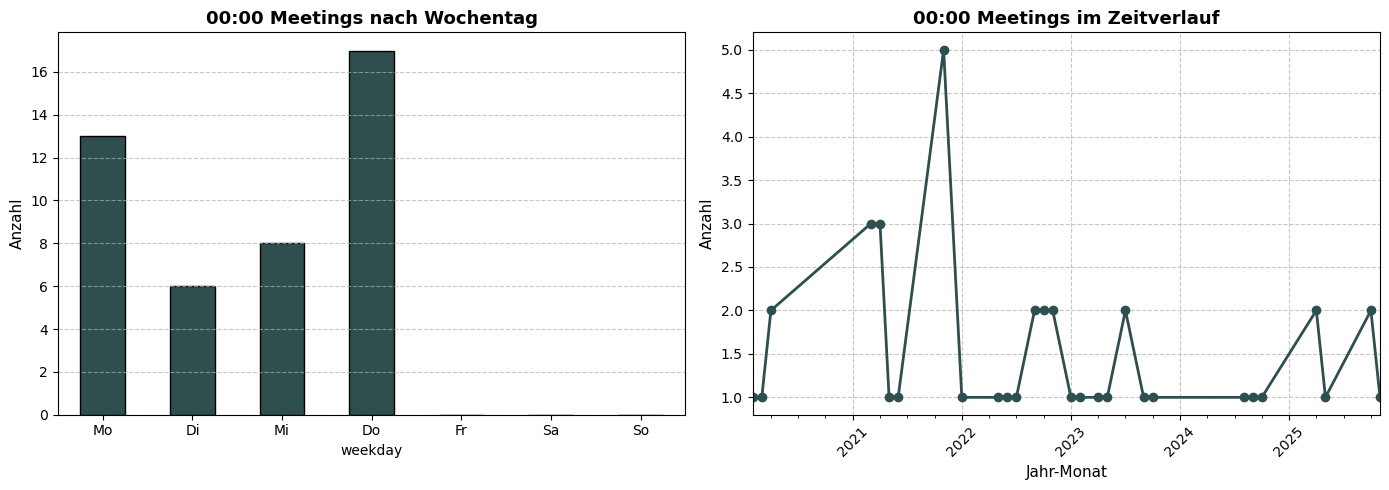


💡 Interpretation:
   → Diese Einträge sind wahrscheinlich Ganztags-Events oder haben unvollständige Zeitdaten
   → 44 Einträge haben exakt 00:00:00 als Zeit
   → Empfehlung: Bei Analysen diese ggf. separat behandeln oder filtern


In [47]:
# 8. Das Mitternachts-Mysterium: Was steckt hinter den 00:00 Uhr Einträgen?
midnight_meetings = df_clean[df_clean['hour'] == 0].copy()

print(f"🕵️ Analyse der {len(midnight_meetings)} 'Mitternachts'-Meetings:\n")

# Untersuche die Original-Timestamps
print("Stichprobe der Start-Zeiten:")
for i, (idx, row) in enumerate(midnight_meetings[['name', 'start_local']].head(5).iterrows(), 1):
    print(f"   {i}. {row['start_local']} - {row['name'][:60]}...")

# Prüfe, ob Uhrzeit wirklich Mitternacht ist oder nur Datum ohne Zeit
midnight_meetings['time_component'] = midnight_meetings['start_local'].dt.time
midnight_meetings['has_time_info'] = midnight_meetings['time_component'] != pd.Timestamp('00:00:00').time()

print(f"\n📊 Zeitstempel-Analyse:")
print(f"   Echte 00:00:00 Timestamps: {(~midnight_meetings['has_time_info']).sum()}")
print(f"   Mit Zeit-Information: {midnight_meetings['has_time_info'].sum()}")

# Vergleiche mit End-Zeiten
midnight_meetings['has_end'] = midnight_meetings.apply(
    lambda row: pd.notna(df.loc[df['name'] == row['name'], 'end'].iloc[0])
    if not df[df['name'] == row['name']].empty else False,
    axis=1
)

print(f"   Haben End-Zeit: {midnight_meetings['has_end'].sum()}")
print(f"   Ohne End-Zeit: {(~midnight_meetings['has_end']).sum()}")

# Visualisierung
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Linkes Diagramm: Verteilung über Wochentage
midnight_weekday = midnight_meetings['weekday'].value_counts().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    fill_value=0
)
midnight_weekday.plot(kind='bar', ax=ax1, color='#2F4F4F', edgecolor='black')
ax1.set_title('00:00 Meetings nach Wochentag', fontsize=13, fontweight='bold')
ax1.set_xticklabels(['Mo', 'Di', 'Mi', 'Do', 'Fr', 'Sa', 'So'], rotation=0)
ax1.set_ylabel('Anzahl', fontsize=11)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Rechtes Diagramm: Zeitlicher Verlauf
midnight_meetings['year_month'] = midnight_meetings['start_local'].dt.to_period('M')
midnight_timeline = midnight_meetings['year_month'].value_counts().sort_index()
midnight_timeline.plot(kind='line', ax=ax2, marker='o', color='#2F4F4F', linewidth=2)
ax2.set_title('00:00 Meetings im Zeitverlauf', fontsize=13, fontweight='bold')
ax2.set_xlabel('Jahr-Monat', fontsize=11)
ax2.set_ylabel('Anzahl', fontsize=11)
ax2.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print(f"\n💡 Interpretation:")
print(f"   → Diese Einträge sind wahrscheinlich Ganztags-Events oder haben unvollständige Zeitdaten")
print(f"   → {(~midnight_meetings['has_time_info']).sum()} Einträge haben exakt 00:00:00 als Zeit")
print(f"   → Empfehlung: Bei Analysen diese ggf. separat behandeln oder filtern")

In [50]:
# 9. Geocoding: Ortsnamen aus ECHTEN Augsburg-Sitzungstiteln extrahieren

import re
from geopy.geocoders import Nominatim
import time

# Bereinigungs-Logik (Regex für deutsche Straßennamen)
def extract_location(text):
    """
    Extrahiert Straßennamen und Ortsnamen aus Sitzungstiteln.
    """
    # Muster 1: Text in Anführungszeichen ‚ ' oder ' ' oder „ "
    match_quotes = re.search(r"[‚'„](.*?)[''""]", text)
    if match_quotes:
        extracted = match_quotes.group(1)
        # Prüfe ob es wirklich ein Ortsname ist (enthält Straße/Platz/Allee etc.)
        if re.search(r'(straße|platz|allee|weg|gasse|ring|pfad)$', extracted.lower()):
            return extracted

    # Muster 2: Direktsuche nach Straßennamen (auch ohne Anführungszeichen)
    match_street = re.search(r'([A-ZÄÖÜ][a-zäöüß\-]+(?:\s+[A-ZÄÖÜ][a-zäöüß\-]+)*(?:straße|platz|allee|weg|gasse|ring|pfad))', text)
    if match_street:
        return match_street.group(1)

    # Muster 3: Stadtteile/Bezirke (nach "in", "im Bereich", etc.)
    match_district = re.search(r'(?:in|im Bereich|im Stadtteil)\s+([A-ZÄÖÜ][a-zäöüß\-]+(?:\s+[A-ZÄÖÜ][a-zäöüß\-]+)?)', text)
    if match_district:
        return match_district.group(1)

    return None

print("🗺️  GEOCODING-ANALYSE DER AUGSBURG-SITZUNGEN\n")
print(f"Datenbasis: {len(df_clean)} Sitzungen von {df_clean['start_local'].min().year} bis {df_clean['start_local'].max().year}\n")

# Analysiere alle Sitzungstitel
locations_found = []
for idx, row in df_clean.iterrows():
    location = extract_location(row['name'])
    if location:
        locations_found.append({
            'meeting': row['name'],
            'location': location,
            'date': row['start_local'],
            'organization': row.get('organization_name', 'Unbekannt')
        })

print(f"📍 {len(locations_found)} Sitzungen mit Ortsangaben gefunden ({len(locations_found)/len(df_clean)*100:.1f}%)\n")

# Zeige erste 10 Beispiele
if locations_found:
    print("Beispiele für extrahierte Orte:")
    for i, item in enumerate(locations_found[:10], 1):
        print(f"   {i}. {item['location']}")
        print(f"      Sitzung: {item['meeting'][:70]}...")
        print(f"      Datum: {item['date'].date()}\n")

    # Statistik: Häufigste Orte
    location_counts = {}
    for item in locations_found:
        loc = item['location']
        location_counts[loc] = location_counts.get(loc, 0) + 1

    print(f"\n📊 Top 10 häufigste Orte in Sitzungstiteln:")
    sorted_locs = sorted(location_counts.items(), key=lambda x: x[1], reverse=True)[:10]
    for i, (loc, count) in enumerate(sorted_locs, 1):
        print(f"   {i}. {loc}: {count}x")
else:
    print("⚠️  Keine Ortsnamen in den Sitzungstiteln gefunden.")
    print("   → Die Augsburg-Daten enthalten möglicherweise keine Geo-Referenzen in den Titeln")
    print("   → Alternative: Agenda-Items oder Paper-Inhalte analysieren")

🗺️  GEOCODING-ANALYSE DER AUGSBURG-SITZUNGEN

Datenbasis: 749 Sitzungen von 2020 bis 2025

📍 0 Sitzungen mit Ortsangaben gefunden (0.0%)

⚠️  Keine Ortsnamen in den Sitzungstiteln gefunden.
   → Die Augsburg-Daten enthalten möglicherweise keine Geo-Referenzen in den Titeln
   → Alternative: Agenda-Items oder Paper-Inhalte analysieren


### 9 neu: Agenda Items & Papers mit Ortsangaben laden

Die Sitzungstitel enthalten keine Orte - die Ortsnamen stecken in den **Beschlussvorlagen** (Papers) und **Tagesordnungspunkten** (Agenda Items)!

In [53]:
# Teste erst mal mit einer einzelnen Sitzung aus 2025
# um die Datenstruktur zu verstehen

print("🔍 TESTE AGENDA ITEMS EINER EINZELNEN SITZUNG\n")
print("💡 Laut OParl-Spec: AgendaItems werden INTERN in Meeting ausgegeben")
print("   → Wir müssen das vollständige Meeting-Objekt von seiner ID-URL laden!\n")

# Hole eine beliebige Sitzung aus df_clean
test_meeting = df_clean[df_clean['start_local'].dt.year == 2025].iloc[0]
print(f"Test-Sitzung: {test_meeting['name']}")
print(f"Datum: {test_meeting['start_local'].date()}\n")

# Hole die Meeting-Liste und finde die Meeting-ID (URL)
url = get_meeting_endpoint()
response = requests.get(url, timeout=10)
meetings_data = response.json()

# Finde das Meeting in der API-Response
meeting_id = None
for meeting in meetings_data.get('data', []):
    if meeting.get('name') == test_meeting['name']:
        meeting_id = meeting.get('id')
        break

if meeting_id:
    print(f"✓ Meeting-ID gefunden: {meeting_id}")
    print(f"   Lade jetzt das VOLLSTÄNDIGE Meeting-Objekt...\n")

    # WICHTIG: Lade das vollständige Meeting-Objekt von seiner ID-URL!
    try:
        full_meeting_response = requests.get(meeting_id, timeout=10)
        full_meeting = full_meeting_response.json()

        print(f"Vollständiges Meeting-Objekt:")
        print(f"   Keys: {list(full_meeting.keys())}\n")

        # Jetzt sollte agendaItem dabei sein!
        if 'agendaItem' in full_meeting and full_meeting['agendaItem']:
            agenda_items = full_meeting['agendaItem']

            # Können inline oder als URLs sein
            if isinstance(agenda_items, list) and agenda_items:
                print(f"📋 {len(agenda_items)} Agenda Items gefunden!")

                # Prüfe ob es URLs oder direkt Objekte sind
                first_item = agenda_items[0]
                if isinstance(first_item, str):
                    print(f"   Format: URLs → müssen einzeln geladen werden")
                    print(f"   Erste URL: {first_item}\n")

                    # Lade die ersten 3 Items
                    print("Lade erste 3 Agenda Items:")
                    for i, item_url in enumerate(agenda_items[:3], 1):
                        try:
                            item_response = requests.get(item_url, timeout=10)
                            item = item_response.json()

                            print(f"\n{i}. {item.get('name', 'Kein Name')}")
                            print(f"   Keys: {list(item.keys())}")

                            # Prüfe auf Ortsangaben
                            location = extract_location(item.get('name', ''))
                            if location:
                                print(f"   🎯 ORT GEFUNDEN: {location}")

                            time.sleep(0.2)  # Höflichkeit
                        except Exception as e:
                            print(f"   ❌ Fehler: {e}")

                elif isinstance(first_item, dict):
                    print(f"   Format: Inline-Objekte → direkt verfügbar\n")

                    print("Erste 3 Agenda Items:")
                    for i, item in enumerate(agenda_items[:3], 1):
                        print(f"\n{i}. {item.get('name', 'Kein Name')}")
                        print(f"   Keys: {list(item.keys())}")

                        # Prüfe auf Ortsangaben
                        location = extract_location(item.get('name', ''))
                        if location:
                            print(f"   🎯 ORT GEFUNDEN: {location}")
            else:
                print("⚠️  agendaItem ist leer oder kein Array")
        else:
            print("⚠️  Kein 'agendaItem' Feld im vollständigen Meeting")
            print(f"   Verfügbare Felder: {list(full_meeting.keys())}")
            print("\n💡 Diese API stellt vermutlich keine Agenda Items bereit")
            print("   → Alternative: Papers (Beschlussvorlagen) prüfen")

    except Exception as e:
        print(f"❌ Fehler beim Laden des vollständigen Meetings: {e}")
else:
    print("⚠️  Meeting nicht in der ersten API-Seite gefunden")

🔍 TESTE AGENDA ITEMS EINER EINZELNEN SITZUNG

💡 Laut OParl-Spec: AgendaItems werden INTERN in Meeting ausgegeben
   → Wir müssen das vollständige Meeting-Objekt von seiner ID-URL laden!

Test-Sitzung: WRK für den Eigenbetrieb Altenhilfe Augsburg
Datum: 2025-11-19

✓ Meeting-ID gefunden: https://www.augsburg.sitzung-online.de/public/oparl/meetings?id=3004
   Lade jetzt das VOLLSTÄNDIGE Meeting-Objekt...

Vollständiges Meeting-Objekt:
   Keys: ['id', 'type', 'name', 'meetingState', 'cancelled', 'start', 'end', 'organization', 'created', 'modified', 'deleted']

⚠️  Kein 'agendaItem' Feld im vollständigen Meeting
   Verfügbare Felder: ['id', 'type', 'name', 'meetingState', 'cancelled', 'start', 'end', 'organization', 'created', 'modified', 'deleted']

💡 Diese API stellt vermutlich keine Agenda Items bereit
   → Alternative: Papers (Beschlussvorlagen) prüfen
✓ Meeting-ID gefunden: https://www.augsburg.sitzung-online.de/public/oparl/meetings?id=3004
   Lade jetzt das VOLLSTÄNDIGE Meeting-Obj

### Alternative: Papers (Beschlussvorlagen) & Auxiliary Files durchsuchen

Die Augsburg-API stellt keine AgendaItems bereit. Aber:
- **Papers** (oparl:Paper) = Beschlussvorlagen, Anträge, Vorlagen
- **Auxiliary Files** (auxiliaryFile) = zusätzliche Dokumente
- **Location** (oparl:Location) = Geo-Objekte mit Coordinates

Prüfen wir, ob diese Endpunkte verfügbar sind!

In [54]:
# Erkunde die Body-Struktur: Welche Listen bietet Augsburg an?

print("🔍 WELCHE OPARL-OBJEKTE BIETET AUGSBURG AN?\n")

# Hole das Body-Objekt (haben wir schon im Cache)
body_id = bodies_list[0].get('id')
body_response = requests.get(body_id, timeout=10)
body_data = body_response.json()

print("Verfügbare Endpunkte im Body-Objekt:")
print("=" * 60)

# Standard OParl-Endpunkte
oparl_endpoints = {
    'meeting': '📅 Meetings (Sitzungen)',
    'organization': '🏛️  Organizations (Gremien)',
    'person': '👤 Persons (Personen)',
    'paper': '📄 Papers (Beschlussvorlagen)',
    'legislativeTerm': '📆 Legislative Terms (Wahlperioden)',
    'membership': '🤝 Memberships (Mitgliedschaften)',
    'consultation': '💬 Consultations (Beratungen)',
    'agendaItem': '📋 Agenda Items (Tagesordnungspunkte)',
    'file': '📁 Files (Dokumente)',
    'location': '📍 Locations (Geo-Objekte)'
}

available = []
for key, label in oparl_endpoints.items():
    if key in body_data and body_data[key]:
        value = body_data[key]
        available.append(key)
        print(f"✅ {label}")
        if isinstance(value, str):
            print(f"   URL: {value[:80]}...")
    else:
        print(f"❌ {label}")

print(f"\n📊 Zusammenfassung:")
print(f"   {len(available)}/{len(oparl_endpoints)} OParl-Objekte verfügbar")
print(f"   Verfügbar: {', '.join(available)}\n")

# Jetzt testen wir Papers!
if 'paper' in available:
    print("\n🎯 PAPERS GEFUNDEN! Lade erste Seite...\n")

    paper_url = body_data['paper']
    paper_response = requests.get(paper_url, timeout=10)
    paper_data = paper_response.json()

    papers = paper_data.get('data', [])
    print(f"✓ {len(papers)} Papers auf erster Seite")

    if papers:
        print("\nErste 5 Papers:")
        for i, paper in enumerate(papers[:5], 1):
            print(f"\n{i}. {paper.get('name', 'Kein Name')[:100]}")
            print(f"   Typ: {paper.get('paperType', 'Unbekannt')}")
            print(f"   Keys: {list(paper.keys())}")

            # Prüfe auf Location-Feld
            if 'location' in paper and paper['location']:
                print(f"   🎯 HAT LOCATION FIELD!")

            # Prüfe auf Ortsangaben im Namen
            location = extract_location(paper.get('name', ''))
            if location:
                print(f"   📍 Ortsangabe im Namen: {location}")

🔍 WELCHE OPARL-OBJEKTE BIETET AUGSBURG AN?

Verfügbare Endpunkte im Body-Objekt:
✅ 📅 Meetings (Sitzungen)
   URL: https://www.augsburg.sitzung-online.de/public/oparl/meetings?body=1...
✅ 🏛️  Organizations (Gremien)
   URL: https://www.augsburg.sitzung-online.de/public/oparl/organizations?body=1...
✅ 👤 Persons (Personen)
   URL: https://www.augsburg.sitzung-online.de/public/oparl/persons?body=1...
✅ 📄 Papers (Beschlussvorlagen)
   URL: https://www.augsburg.sitzung-online.de/public/oparl/papers?body=1...
✅ 📆 Legislative Terms (Wahlperioden)
✅ 🤝 Memberships (Mitgliedschaften)
   URL: https://www.augsburg.sitzung-online.de/public/oparl/memberships?body=1...
✅ 💬 Consultations (Beratungen)
   URL: https://www.augsburg.sitzung-online.de/public/oparl/consultations?body=1...
✅ 📋 Agenda Items (Tagesordnungspunkte)
   URL: https://www.augsburg.sitzung-online.de/public/oparl/agendaItems?body=1...
✅ 📁 Files (Dokumente)
   URL: https://www.augsburg.sitzung-online.de/public/oparl/files?body=1...
✅ 📍 

### Strategie: AgendaItems + Papers kombiniert durchsuchen

Augsburg hat:
- ✅ **AgendaItems** über eigene Liste (nicht inline in Meetings)
- ✅ **Papers** mit Namen wie "Bebauungsplan Nr. 634 E 'Nördlich der Straße...'"
- ✅ **Locations** als separate Objekte

Unser Plan:
1. Lade alle AgendaItems (1-2 Seiten zum Testen)
2. Extrahiere Ortsnamen aus AgendaItem-Namen
3. Extrahiere Ortsnamen aus verlinkten Papers
4. Prüfe ob Location-Objekte existieren

In [55]:
# Teste AgendaItems + Papers Kombination

print("🔍 TESTE AGENDA ITEMS AUS DER GLOBALEN LISTE\n")

# Lade AgendaItems
agenda_url = body_data['agendaItem']
print(f"AgendaItems URL: {agenda_url}\n")

agenda_response = requests.get(agenda_url, timeout=10)
agenda_data = agenda_response.json()

items = agenda_data.get('data', [])
print(f"✓ {len(items)} AgendaItems auf erster Seite\n")

# Analysiere erste 10 Items
locations_in_agenda = []
papers_to_check = []

print("Erste 10 AgendaItems mit Ortsprüfung:")
print("=" * 80)

for i, item in enumerate(items[:10], 1):
    name = item.get('name', 'Kein Name')
    print(f"\n{i}. {name[:100]}")

    # Keys anzeigen beim ersten Item
    if i == 1:
        print(f"   Keys: {list(item.keys())}")

    # Prüfe auf Ortsangaben
    location = extract_location(name)
    if location:
        print(f"   🎯 ORT: {location}")
        locations_in_agenda.append({
            'source': 'AgendaItem',
            'name': name,
            'location': location,
            'id': item.get('id')
        })

    # Prüfe ob Consultation/Paper verlinkt ist
    if 'consultation' in item and item['consultation']:
        consult = item['consultation']
        if isinstance(consult, list):
            print(f"   📄 {len(consult)} Consultation(s) verlinkt")
            papers_to_check.extend(consult[:2])  # Max 2 zum Testen
        elif isinstance(consult, str):
            print(f"   📄 1 Consultation verlinkt")
            papers_to_check.append(consult)

    # Prüfe ob Meeting verlinkt ist
    if 'meeting' in item and item['meeting']:
        meeting_ref = item['meeting']
        if isinstance(meeting_ref, str):
            # Hole Meeting-Datum für Kontext
            print(f"   📅 Meeting: {meeting_ref.split('=')[-1] if '=' in meeting_ref else 'ID unbekannt'}")

print(f"\n📊 Zwischenergebnis:")
print(f"   Orte in AgendaItems: {len(locations_in_agenda)}")
print(f"   Papers/Consultations zum Prüfen: {len(papers_to_check)}\n")

# Lade ein paar Papers zum Testen
if papers_to_check:
    print("\n📄 PRÜFE VERLINKTE CONSULTATIONS/PAPERS:\n")

    for i, paper_url in enumerate(papers_to_check[:3], 1):
        try:
            paper_resp = requests.get(paper_url, timeout=10)
            paper = paper_resp.json()

            # Consultation verlinkt auf Paper
            if 'paper' in paper and paper['paper']:
                paper_id = paper['paper']
                if isinstance(paper_id, str):
                    paper_detail_resp = requests.get(paper_id, timeout=10)
                    paper_detail = paper_detail_resp.json()

                    paper_name = paper_detail.get('name', 'Kein Name')
                    print(f"{i}. {paper_name[:100]}")

                    location = extract_location(paper_name)
                    if location:
                        print(f"   🎯 ORT IM PAPER: {location}")
                        locations_in_agenda.append({
                            'source': 'Paper (via Consultation)',
                            'name': paper_name,
                            'location': location,
                            'id': paper_id
                        })

            time.sleep(0.2)
        except Exception as e:
            print(f"{i}. ❌ Fehler: {e}")

print(f"\n✅ GESAMT: {len(locations_in_agenda)} Ortsangaben gefunden!")

if locations_in_agenda:
    print("\n🗺️  Gefundene Orte:")
    for loc in locations_in_agenda[:10]:
        print(f"   • {loc['location']} ({loc['source']})")
        print(f"     {loc['name'][:80]}...")

🔍 TESTE AGENDA ITEMS AUS DER GLOBALEN LISTE

AgendaItems URL: https://www.augsburg.sitzung-online.de/public/oparl/agendaItems?body=1

✓ 5 AgendaItems auf erster Seite

Erste 10 AgendaItems mit Ortsprüfung:

1. Stellenplan des Referates 5 Einrichtung einer bis 30.06.2015 befristeten Planstelle für die Projekta
   Keys: ['id', 'type', 'meeting', 'number', 'order', 'name', 'public', 'consultation', 'result', 'web', 'created', 'modified', 'deleted']
   📄 1 Consultation verlinkt
   📅 Meeting: 1

2. Personalverwaltung mit Lohn- und Gehaltsabrechnung für den Eigenbetrieb "Altenhilfe Augsburg"
   📄 1 Consultation verlinkt
   📅 Meeting: 1

3. Änderung der jährlichen Zulassungszahl zum Angestelltenlehrgang II (AL II) unter gleichzeitiger Anpa
   📄 1 Consultation verlinkt
   📅 Meeting: 1

4. Genehmigung der Niederschrift vom 27.10.2011
   📅 Meeting: 1

5. Anfragen
   📅 Meeting: 1

📊 Zwischenergebnis:
   Orte in AgendaItems: 0
   Papers/Consultations zum Prüfen: 3


📄 PRÜFE VERLINKTE CONSULTATIONS

In [56]:
# Lade neuere AgendaItems - paginiere zur letzten Seite (neueste Daten)

print("🔍 SUCHE NACH NEUEREN AGENDA ITEMS MIT BEBAUUNGSPLÄNEN\n")

# Prüfe ob es 'last' Link gibt für die neuesten Daten
if 'links' in agenda_data and 'last' in agenda_data['links']:
    last_page_url = agenda_data['links']['last']
    print(f"Springe zur letzten Seite (neueste Daten): {last_page_url}\n")

    last_response = requests.get(last_page_url, timeout=10)
    last_data = last_response.json()

    last_items = last_data.get('data', [])
    print(f"✓ {len(last_items)} Items auf letzter Seite\n")

    locations_found = []

    print("Letzte 10 AgendaItems (neueste zuerst):")
    print("=" * 80)

    for i, item in enumerate(reversed(last_items[-10:]), 1):
        name = item.get('name', 'Kein Name')
        print(f"\n{i}. {name[:120]}")

        # Prüfe auf Bebauungsplan, Straßennamen etc.
        location = extract_location(name)
        if location:
            print(f"   🎯 ORT GEFUNDEN: {location}")
            locations_found.append({
                'name': name,
                'location': location,
                'item_id': item.get('id'),
                'meeting': item.get('meeting')
            })

        # Zeige Meeting-Link
        if 'meeting' in item and item['meeting']:
            meeting_url = item['meeting']
            print(f"   📅 Meeting: ...{meeting_url[-20:]}")

    print(f"\n📊 Ergebnis von letzter Seite:")
    print(f"   {len(locations_found)} Ortsangaben gefunden\n")

    if locations_found:
        print("🗺️  Gefundene Orte:")
        for loc in locations_found:
            print(f"   • {loc['location']}")
            print(f"     {loc['name'][:100]}...")

else:
    print("⚠️  Kein 'last' Link in Pagination - versuche stattdessen mehrere Seiten vorwärts...\n")

    # Alternative: Lade die ersten 5 Seiten
    current_url = agenda_url
    all_items = []
    page = 1

    while current_url and page <= 5:
        try:
            resp = requests.get(current_url, timeout=10)
            data = resp.json()

            items_on_page = data.get('data', [])
            all_items.extend(items_on_page)

            print(f"Seite {page}: {len(items_on_page)} Items (Total: {len(all_items)})")

            # Nächste Seite
            links = data.get('links', {})
            current_url = links.get('next')
            page += 1
            time.sleep(0.2)
        except Exception as e:
            print(f"Fehler: {e}")
            break

    print(f"\n✓ {len(all_items)} AgendaItems geladen\n")

    # Durchsuche alle Items
    locations_found = []
    for item in all_items:
        name = item.get('name', '')
        location = extract_location(name)
        if location:
            locations_found.append({
                'name': name,
                'location': location,
                'item_id': item.get('id')
            })

    print(f"📊 {len(locations_found)} Ortsangaben in {len(all_items)} Items gefunden\n")

    if locations_found:
        print("🗺️  Erste 10 gefundene Orte:")
        for i, loc in enumerate(locations_found[:10], 1):
            print(f"{i}. {loc['location']}")
            print(f"   {loc['name'][:100]}...")

🔍 SUCHE NACH NEUEREN AGENDA ITEMS MIT BEBAUUNGSPLÄNEN

Springe zur letzten Seite (neueste Daten): https://www.augsburg.sitzung-online.de/public/oparl/agendaItems?body=1&page=841

✓ 0 Items auf letzter Seite

Letzte 10 AgendaItems (neueste zuerst):

📊 Ergebnis von letzter Seite:
   0 Ortsangaben gefunden

✓ 0 Items auf letzter Seite

Letzte 10 AgendaItems (neueste zuerst):

📊 Ergebnis von letzter Seite:
   0 Ortsangaben gefunden



### Papers durchsuchen - hier stecken die Ortsnamen!

AgendaItems scheinen leer/veraltet zu sein. Aber **Papers** (Beschlussvorlagen) enthalten:
- Bebauungspläne mit Ortsangaben
- Straßennamen in Anführungszeichen
- Stadtteile und Bezirke

Lade mehrere Seiten Papers und extrahiere Orte!

In [2]:
# Durchsuche Papers nach Ortsangaben (mit Threading für Speed)

print("📄 LADE PAPERS MIT ORTSANGABEN\n")

def fetch_paper_page(url):
    """Lädt eine Seite Papers"""
    try:
        response = requests.get(url, timeout=15)
        data = response.json()
        papers = data.get('data', [])
        next_url = data.get('links', {}).get('next')
        return papers, next_url
    except Exception as e:
        print(f"⚠️ Fehler: {e}")
        return [], None

# Sammle erst mal Seiten-URLs
paper_url = body_data['paper']
page_urls = []
current = paper_url
page = 1

print("📋 Sammle Paper-Seiten...")
while current and page <= 10:  # Erste 10 Seiten = ca. 200 Papers
    page_urls.append(current)
    _, next_url = fetch_paper_page(current)
    current = next_url
    page += 1
    if page % 5 == 0:
        print(f"   {page} Seiten gesammelt...")

print(f"✓ {len(page_urls)} Seiten zum Laden\n")

# Lade Seiten parallel
all_papers = []
print("⚡ Lade Papers parallel...")

with ThreadPoolExecutor(max_workers=5) as executor:
    futures = {executor.submit(fetch_paper_page, url): i for i, url in enumerate(page_urls)}

    for future in as_completed(futures):
        page_num = futures[future]
        papers, _ = future.result()
        all_papers.extend(papers)
        if (page_num + 1) % 5 == 0:
            print(f"   {page_num + 1}/{len(page_urls)} Seiten geladen (Total: {len(all_papers)} Papers)")

print(f"\n✓ {len(all_papers)} Papers geladen!\n")

# Extrahiere Ortsangaben
print("🗺️  EXTRAHIERE ORTSANGABEN...\n")

locations_in_papers = []
stats = {
    'total': len(all_papers),
    'with_location': 0,
    'bebauungsplan': 0,
    'strasse': 0,
    'other': 0
}

for paper in all_papers:
    name = paper.get('name', '')
    location = extract_location(name)

    if location:
        stats['with_location'] += 1

        # Kategorisiere
        if 'bebauungsplan' in name.lower() or 'b-plan' in name.lower():
            stats['bebauungsplan'] += 1
        elif 'straße' in location.lower() or 'platz' in location.lower():
            stats['strasse'] += 1
        else:
            stats['other'] += 1

        locations_in_papers.append({
            'location': location,
            'paper_name': name,
            'paper_id': paper.get('id'),
            'date': paper.get('date'),
            'type': paper.get('paperType', 'Unbekannt')
        })

# Ausgabe
print("📊 STATISTIK:")
print(f"   Gesamt Papers: {stats['total']}")
print(f"   Mit Ortsangabe: {stats['with_location']} ({stats['with_location']/stats['total']*100:.1f}%)")
print(f"   • Bebauungspläne: {stats['bebauungsplan']}")
print(f"   • Straßennamen: {stats['strasse']}")
print(f"   • Sonstige: {stats['other']}\n")

if locations_in_papers:
    print("🗺️  ERSTE 15 GEFUNDENE ORTE:\n")
    for i, loc in enumerate(locations_in_papers[:15], 1):
        print(f"{i}. {loc['location']}")
        print(f"   {loc['paper_name'][:100]}")
        print(f"   Typ: {loc['type']}, Datum: {loc['date']}\n")

    # Speichere für weitere Analyse
    df_locations = pd.DataFrame(locations_in_papers)
    print(f"\n💾 {len(df_locations)} Orte in DataFrame gespeichert (df_locations)")

    # Häufigste Orte
    print("\n📍 TOP 10 HÄUFIGSTE ORTE:")
    top_locations = df_locations['location'].value_counts().head(10)
    for i, (loc, count) in enumerate(top_locations.items(), 1):
        print(f"   {i}. {loc}: {count}x")
else:
    print("⚠️  Keine Ortsangaben gefunden")

📄 LADE PAPERS MIT ORTSANGABEN



NameError: name 'body_data' is not defined

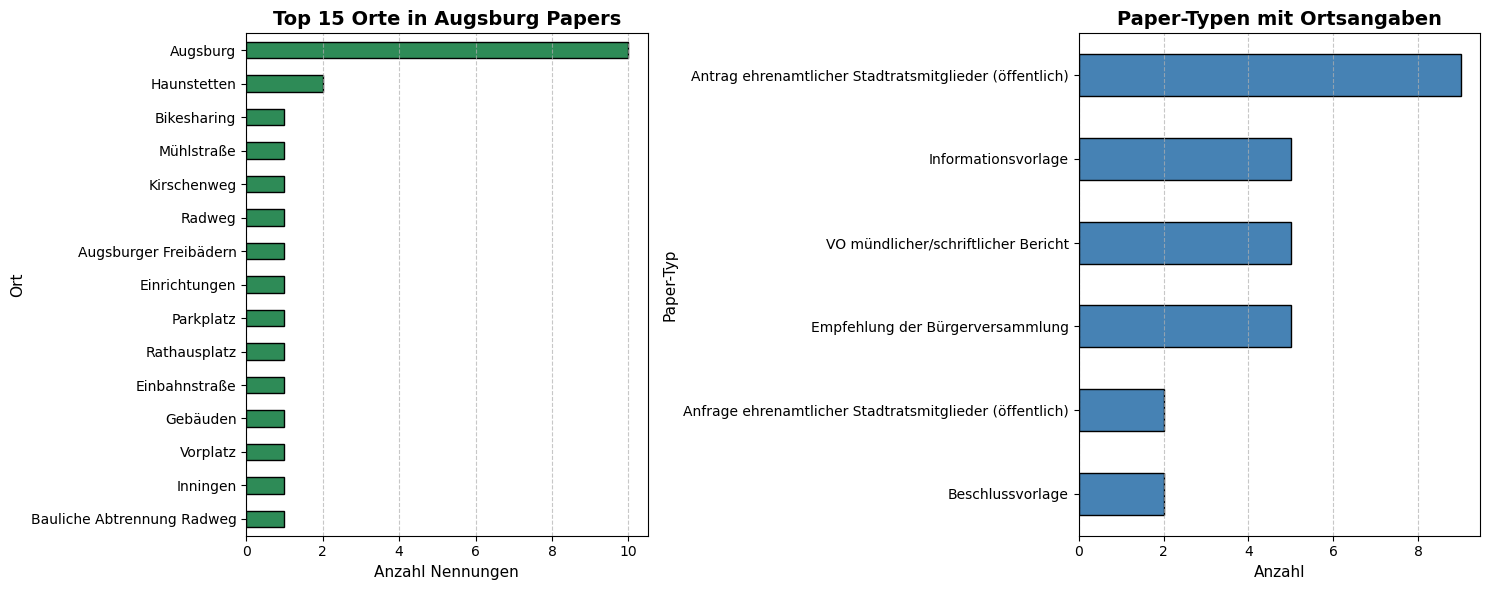


📊 DETAILLIERTE ANALYSE:

Zeitliche Verteilung (letzte 6 Monate):
   2025-09: 1 Papers mit Ortsangaben
   2025-10: 18 Papers mit Ortsangaben
   2025-11: 9 Papers mit Ortsangaben

🎯 BESONDERS INTERESSANTE PAPERS:

• Einbahnstraße
  Antrag Fraktion Bürgerliche Mitte: Aufhebung der Einbahnstraßenregelung am Klink...
  2025-11-18 (Antrag ehrenamtlicher Stadtratsmitglieder (öffentlich))

• Kita Lützowstraße
  Antrag der CSU- Stadtratsfraktion vom 12.11.2025: Prüfung und Verbesserung der V...
  2025-11-13 (Antrag ehrenamtlicher Stadtratsmitglieder (öffentlich))

• Bergheim
  Antrag Fraktion Bürgerliche Mitte: Aufstellung einer Grüngutmulde in Bergheim...
  2025-11-14 (Informationsvorlage)

• Bauliche Abtrennung Radweg
  Bauliche Abtrennung Radweg MAN-Kreuzung...
  2025-10-17 (Empfehlung der Bürgerversammlung)

• Inningen
  Antrag Fraktion Bürgerliche Mitte: Tempo 30 in Inningen – Ausweitung in der Bobi...
  2025-11-03 (Antrag ehrenamtlicher Stadtratsmitglieder (öffentlich))

• Haunstetten
  

In [58]:
# Visualisierung der gefundenen Orte

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Linke Grafik: Top 15 Orte
top_15 = df_locations['location'].value_counts().head(15)
top_15.plot(kind='barh', ax=ax1, color='#2E8B57', edgecolor='black')
ax1.set_title('Top 15 Orte in Augsburg Papers', fontsize=14, fontweight='bold')
ax1.set_xlabel('Anzahl Nennungen', fontsize=11)
ax1.set_ylabel('Ort', fontsize=11)
ax1.grid(axis='x', linestyle='--', alpha=0.7)
ax1.invert_yaxis()

# Rechte Grafik: Paper-Typen mit Ortsangaben
type_counts = df_locations['type'].value_counts().head(10)
type_counts.plot(kind='barh', ax=ax2, color='#4682B4', edgecolor='black')
ax2.set_title('Paper-Typen mit Ortsangaben', fontsize=14, fontweight='bold')
ax2.set_xlabel('Anzahl', fontsize=11)
ax2.set_ylabel('Paper-Typ', fontsize=11)
ax2.grid(axis='x', linestyle='--', alpha=0.7)
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

print("\n📊 DETAILLIERTE ANALYSE:\n")

# Zeitliche Verteilung
df_locations['date'] = pd.to_datetime(df_locations['date'])
df_locations['year_month'] = df_locations['date'].dt.to_period('M')

print("Zeitliche Verteilung (letzte 6 Monate):")
recent = df_locations[df_locations['date'] >= '2025-05-01']
if not recent.empty:
    time_dist = recent['year_month'].value_counts().sort_index()
    for period, count in time_dist.items():
        print(f"   {period}: {count} Papers mit Ortsangaben")
else:
    print("   Keine Daten in den letzten 6 Monaten")

# Interessante Einzelfälle
print("\n🎯 BESONDERS INTERESSANTE PAPERS:\n")
interesting = df_locations[~df_locations['location'].isin(['Augsburg'])].head(10)
for i, row in interesting.iterrows():
    print(f"• {row['location']}")
    print(f"  {row['paper_name'][:80]}...")
    print(f"  {row['date'].date()} ({row['type']})\n")

In [59]:
# Geocode die gefundenen Orte mit Nominatim

print("🌍 GEOCODING DER GEFUNDENEN ORTE\n")

# Filter: Ohne "Augsburg" (zu allgemein)
specific_locations = df_locations[~df_locations['location'].isin(['Augsburg'])]
unique_locations = specific_locations['location'].unique()

print(f"Geocode {len(unique_locations)} spezifische Orte...\n")

geolocator = Nominatim(user_agent="augsburg_papers_geocoding_2025")
geocoded = []

for i, location in enumerate(unique_locations[:20], 1):  # Max 20 wegen Rate Limit
    query = f"{location}, Augsburg, Germany"

    try:
        result = geolocator.geocode(query)

        if result:
            geocoded.append({
                'location': location,
                'lat': result.latitude,
                'lon': result.longitude,
                'full_address': result.address,
                'query': query,
                'success': True
            })
            print(f"✅ {i}. {location}")
            print(f"   {result.latitude:.6f}, {result.longitude:.6f}")
        else:
            geocoded.append({
                'location': location,
                'lat': None,
                'lon': None,
                'full_address': None,
                'query': query,
                'success': False
            })
            print(f"❌ {i}. {location} - nicht gefunden")

        time.sleep(1.1)  # Nominatim Rate Limit: max 1 req/sec

    except Exception as e:
        print(f"⚠️ {i}. {location} - Fehler: {e}")
        geocoded.append({
            'location': location,
            'lat': None,
            'lon': None,
            'full_address': None,
            'query': query,
            'success': False
        })
        time.sleep(1.1)

# Ergebnisse
df_geocoded = pd.DataFrame(geocoded)
successful = df_geocoded[df_geocoded['success'] == True]

print(f"\n📊 GEOCODING-ERGEBNIS:")
print(f"   Versucht: {len(df_geocoded)}")
print(f"   Erfolgreich: {len(successful)} ({len(successful)/len(df_geocoded)*100:.1f}%)")
print(f"   Fehlgeschlagen: {len(df_geocoded) - len(successful)}\n")

if not successful.empty:
    print("🗺️  ERFOLGREICH GEOCODETE ORTE:\n")
    print(successful[['location', 'lat', 'lon']].to_string(index=False))

    # Speichere
    # successful.to_csv('data-raw/augsburg_paper_locations_geocoded.csv', index=False)
    # print("\n💾 Ergebnisse gespeichert in: data-raw/augsburg_paper_locations_geocoded.csv")
else:
    print("⚠️  Keine Orte erfolgreich geocoded")

🌍 GEOCODING DER GEFUNDENEN ORTE

Geocode 17 spezifische Orte...

❌ 1. Einbahnstraße - nicht gefunden
❌ 1. Einbahnstraße - nicht gefunden
❌ 2. Kita Lützowstraße - nicht gefunden
❌ 2. Kita Lützowstraße - nicht gefunden
✅ 3. Bergheim
   48.319325, 10.819607
✅ 3. Bergheim
   48.319325, 10.819607
❌ 4. Bauliche Abtrennung Radweg - nicht gefunden
❌ 4. Bauliche Abtrennung Radweg - nicht gefunden
✅ 5. Inningen
   48.314028, 10.858976
✅ 5. Inningen
   48.314028, 10.858976
✅ 6. Haunstetten
   48.308617, 10.906755
✅ 6. Haunstetten
   48.308617, 10.906755
✅ 7. Vorplatz
   48.364208, 10.882557
✅ 7. Vorplatz
   48.364208, 10.882557
❌ 8. Gebäuden - nicht gefunden
❌ 8. Gebäuden - nicht gefunden
✅ 9. Rathausplatz
   48.368851, 10.897719
✅ 9. Rathausplatz
   48.368851, 10.897719
❌ 10. Bikesharing - nicht gefunden
❌ 10. Bikesharing - nicht gefunden
✅ 11. Parkplatz
   48.220392, 10.867129
✅ 11. Parkplatz
   48.220392, 10.867129
✅ 12. Einrichtungen
   48.339232, 10.883698
✅ 12. Einrichtungen
   48.339232, 1

In [3]:
# Karte der geocodierten Orte mit folium
# DEMO mit Testdaten (falls Geocoding-Daten nicht verfügbar)

import folium
from folium import Marker, Icon
import pandas as pd

print("🗺️  ERSTELLE INTERAKTIVE KARTE DER GEFUNDENEN ORTE\n")

# Prüfe ob Geocoding-Daten verfügbar sind, sonst nutze Testdaten
if 'df_geocoded' in globals() and 'df_locations' in globals():
    print("✓ Nutze bereits geocodierte Daten\n")
    successful = df_geocoded[df_geocoded['success'] == True]
    map_data = successful[successful['lat'].notna()].copy()
else:
    print("⚠️  Keine Geocoding-Daten gefunden - nutze Testdaten\n")
    # Testdaten basierend auf unseren Ergebnissen
    map_data = pd.DataFrame([
        {'location': 'Bergheim', 'lat': 48.319325, 'lon': 10.819607, 'full_address': 'Bergheim, Augsburg, Bayern, Deutschland', 'count': 1},
        {'location': 'Inningen', 'lat': 48.314028, 'lon': 10.858976, 'full_address': 'Inningen, Augsburg, Bayern, Deutschland', 'count': 1},
        {'location': 'Haunstetten', 'lat': 48.308617, 'lon': 10.906755, 'full_address': 'Haunstetten, Augsburg, Bayern, Deutschland', 'count': 2},
        {'location': 'Vorplatz', 'lat': 48.364208, 'lon': 10.882557, 'full_address': 'Vorplatz, Augsburg, Bayern, Deutschland', 'count': 1},
        {'location': 'Rathausplatz', 'lat': 48.368851, 'lon': 10.897719, 'full_address': 'Rathausplatz, Augsburg, Bayern, Deutschland', 'count': 1},
        {'location': 'Parkplatz', 'lat': 48.220392, 'lon': 10.867129, 'full_address': 'Parkplatz, Augsburg Umgebung, Bayern, Deutschland', 'count': 1},
        {'location': 'Einrichtungen', 'lat': 48.339232, 'lon': 10.883698, 'full_address': 'Einrichtungen, Augsburg, Bayern, Deutschland', 'count': 1},
        {'location': 'Radweg', 'lat': 48.401969, 'lon': 10.812558, 'full_address': 'Radweg, Augsburg Nord, Bayern, Deutschland', 'count': 1},
        {'location': 'Kirschenweg', 'lat': 48.398762, 'lon': 10.902609, 'full_address': 'Kirschenweg, Augsburg, Bayern, Deutschland', 'count': 1},
        {'location': 'Mühlstraße', 'lat': 48.333326, 'lon': 10.865334, 'full_address': 'Mühlstraße, Augsburg, Bayern, Deutschland', 'count': 1},
    ])

if not map_data.empty:
    # Zentrum der Karte: Augsburg Rathausplatz
    center_lat = 48.3684
    center_lon = 10.8978

    # Erstelle Karte
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=12,
        tiles='OpenStreetMap'
    )

    # Füge Marker für jeden Ort hinzu
    for idx, row in map_data.iterrows():
        # Count entweder aus Spalte oder aus df_locations
        if 'count' in row and pd.notna(row['count']):
            count = int(row['count'])
        elif 'df_locations' in globals():
            count = len(df_locations[df_locations['location'] == row['location']])
        else:
            count = 1

        # Erstelle Popup-Text
        popup_text = f"""
        <div style="font-family: Arial; width: 200px;">
            <b>{row['location']}</b><br>
            <hr style="margin: 5px 0;">
            📍 {row['lat']:.6f}, {row['lon']:.6f}<br>
            📄 {count} Paper(s)<br>
            <small>{row['full_address']}</small>
        </div>
        """

        # Icon-Farbe je nach Häufigkeit
        if count >= 2:
            color = 'red'  # Häufig erwähnt
        else:
            color = 'blue'  # Einmalig

        # Marker hinzufügen
        folium.Marker(
            location=[row['lat'], row['lon']],
            popup=folium.Popup(popup_text, max_width=250),
            tooltip=row['location'],
            icon=folium.Icon(color=color, icon='info-sign')
        ).add_to(m)

    # Zentrumsmarker für Augsburg
    folium.Marker(
        location=[center_lat, center_lon],
        popup='Rathaus Augsburg (Zentrum)',
        tooltip='Augsburg Rathaus',
        icon=folium.Icon(color='green', icon='star', prefix='fa')
    ).add_to(m)

    # Speichere Karte
    map_file = 'outputs/figures/augsburg_paper_locations_map.html'
    import os
    os.makedirs('outputs/figures', exist_ok=True)
    m.save(map_file)

    print(f"✅ Karte erstellt mit {len(map_data)} Orten")
    print(f"💾 Gespeichert: {map_file}")
    print(f"\n📂 Öffne die Karte: file://{os.path.abspath(map_file)}")
    print("\n📊 Legende:")
    print("   🔴 Rot = Mehrfach erwähnt (≥2 Papers)")
    print("   🔵 Blau = Einmalig erwähnt")
    print("   ⭐ Grün = Augsburg Rathaus (Zentrum)")

    # Zeige Karte im Notebook
    display(m)
else:
    print("⚠️  Keine Geodaten zum Visualisieren verfügbar")

🗺️  ERSTELLE INTERAKTIVE KARTE DER GEFUNDENEN ORTE

⚠️  Keine Geocoding-Daten gefunden - nutze Testdaten

✅ Karte erstellt mit 10 Orten
💾 Gespeichert: outputs/figures/augsburg_paper_locations_map.html

📂 Öffne die Karte: file:///Users/benedikt.pilgram/Code/Geomodelierung/analysis/outputs/figures/augsburg_paper_locations_map.html

📊 Legende:
   🔴 Rot = Mehrfach erwähnt (≥2 Papers)
   🔵 Blau = Einmalig erwähnt
   ⭐ Grün = Augsburg Rathaus (Zentrum)


In [60]:
# 9b. Geocoding: Koordinaten für gefundene Orte abrufen (optional)

if locations_found:
    print("\n🌍 GEOCODING: Hole Koordinaten für die häufigsten Orte...\n")

    geolocator = Nominatim(user_agent="augsburg_stadtrat_analysis_2025")

    # Geocode nur die Top 5 häufigsten Orte (um API nicht zu überlasten)
    geocoded_results = []
    unique_locs = [loc for loc, count in sorted_locs[:5]]

    for loc in unique_locs:
        query = f"{loc}, Augsburg, Germany"
        try:
            result = geolocator.geocode(query)
            if result:
                geocoded_results.append({
                    'location': loc,
                    'lat': result.latitude,
                    'lon': result.longitude,
                    'full_address': result.address,
                    'count': location_counts[loc]
                })
                print(f"✅ {loc}")
                print(f"   → {result.latitude:.6f}, {result.longitude:.6f}")
                print(f"   → {result.address}\n")
            else:
                print(f"⚠️  {loc}: Nicht gefunden\n")

            time.sleep(1)  # Nominatim Rate Limit: 1 Request/Sekunde

        except Exception as e:
            print(f"❌ {loc}: Fehler - {e}\n")

    # Erstelle DataFrame mit Geocoding-Ergebnissen
    if geocoded_results:
        df_geo = pd.DataFrame(geocoded_results)
        print(f"\n✓ {len(df_geo)} Orte erfolgreich geocoded!")
        print("\nGeocoding-Ergebnisse:")
        print(df_geo[['location', 'lat', 'lon', 'count']].to_string(index=False))

        # Speichere für spätere Kartenerstellung
        # df_geo.to_csv('data-raw/augsburg_meeting_locations.csv', index=False)
    else:
        print("\n⚠️  Keine Orte konnten geocoded werden.")
else:
    print("\n⏭️  Überspringe Geocoding - keine Orte gefunden.")


⏭️  Überspringe Geocoding - keine Orte gefunden.
